X.9.4

Сингулярно-возмущенная система — модель двухлампового
генератора Фрюгауфа:
$$
\begin{cases}
\epsilon*x'_{1} = -\alpha * (y_{1} - y_{2}) + \phi(x_{1}) - x_{2} \\
\epsilon*x'_{2} =  \alpha * (y_{1} - y_{2}) + \phi(x_{2}) - x_{1} \\
y'_{1} = x_{1} \\
y'_{2} = x_{2} \\
\end{cases}
$$

Здесь $\alpha > 0 $ -- константа порядка единицы, функция $\phi(u) = -tg(\pi*u / 2)$, 
$x_{1}(0)=x_{2}(0)=0$, $y_{1}=2$, $y_{2}=0$, $T_{k}=20$, $\epsilon=10^{-3},10^{-6}$

In [46]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [47]:
# Constants
alpha = 1
epsilons = [1e-3, 1e-6]  # We'll solve for both values of epsilon
T_k = 20
dt = 0.001  # time step
N = int(T_k / dt)  # number of steps

time = np.linspace(0, T_k, N)
phi = lambda u: -np.tan(np.pi * u / 2)  # phi function

# Define the system of ODEs
def odes_system(t, vars, epsilon):
    x1, x2, y1, y2 = vars
    dx1_dt = (-alpha * (y1 - y2) + phi(x1) - x2) / epsilon
    dx2_dt = (alpha * (y1 - y2) + phi(x2) - x1) / epsilon
    dy1_dt = x1
    dy2_dt = x2
    return np.array([dx1_dt, dx2_dt, dy1_dt, dy2_dt])


def rk4_step(y_old, h, t, epsilon):
    k1 = odes_system(t, y_old, epsilon)
    k2 = odes_system(t + 0.5 * h, y_old + 0.5 * h * k1, epsilon)
    k3 = odes_system(t + 0.5 * h, y_old + 0.5 * h * k2, epsilon)
    k4 = odes_system(t + h, y_old + h * k3, epsilon)
    y_new = y_old + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    return y_new

## BDF 4 from library.

Воспользуемся решением системы из библиотеки, чтобы было с чем сравнивать результаты


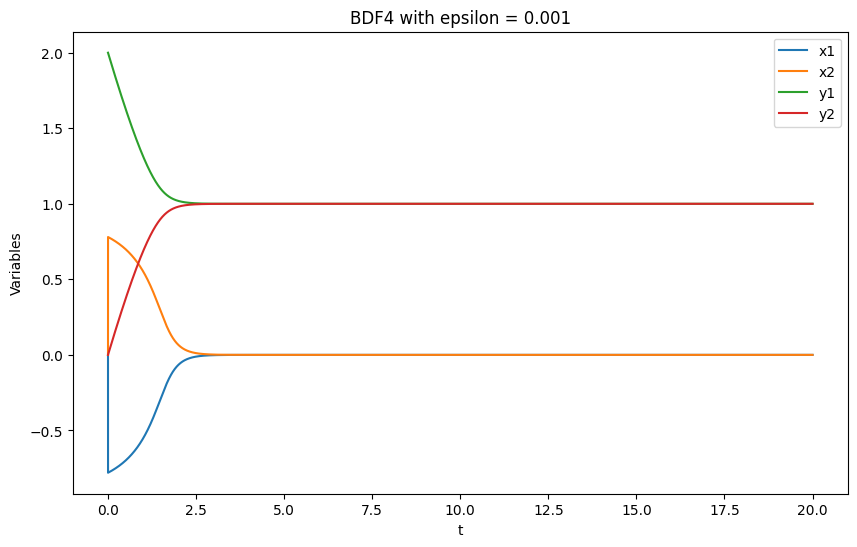

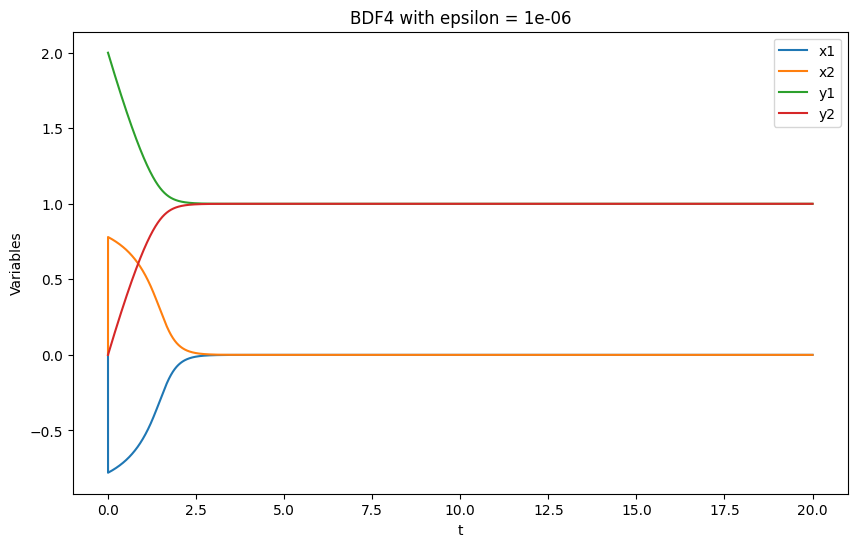

In [48]:

init_values = [0, 0, 2, 0]
t_span = (0, T_k)
sol_dicts = []

for epsilon in epsilons:
    sol = solve_ivp(odes_system, t_span, init_values, method='BDF', args=(epsilon,), dense_output=True)
    sol_dicts.append(sol)

# Plotting the solution for each epsilon
time = np.linspace(0, T_k, N)
for i, epsilon in enumerate(epsilons):
    plt.figure(figsize=(10, 6))
    sol = sol_dicts[i].sol(time)
    plt.plot(time, sol[0], label='x1')
    plt.plot(time, sol[1], label='x2')
    plt.plot(time, sol[2], label='y1')
    plt.plot(time, sol[3], label='y2')
    plt.title(f'BDF4 with epsilon = {epsilon}')
    plt.xlabel('t')
    plt.ylabel('Variables')
    plt.legend()
    plt.show()

## 1) Неявные методы типа Рунге-Кутты 

Можно заметить, что метод Рунге-Кутты, при очень маленьком epsilon (10e-6) сходится только при очень маленьком шаге, что занимает значительное время вычислений (2 минуты 14 секунд)

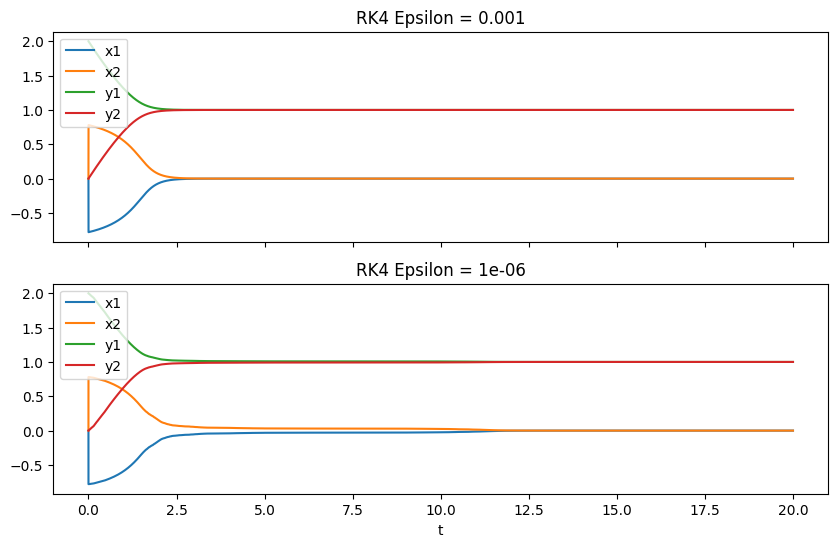

In [49]:
dt = 0.0005  # time step
N = int(T_k / dt)  # number of steps


# IRK4 method (implicit)
def IRK4_step(vars, t, dt, epsilon):
    def equations(z):
        k1, k2, k3, k4 = z[:4], z[4:8], z[8:12], z[12:]
        y1 = vars + dt/2 * (k1 + k2)
        y2 = vars + dt/2 * (k2 + k3)
        y3 = vars + dt * k3
        f1 = odes_system(t, vars + dt/6 * (k1 + 2*k2 + 2*k3 + k4), epsilon) - k1
        f2 = odes_system(t + dt/2, y1, epsilon) - k2
        f3 = odes_system(t + dt/2, y2, epsilon) - k3
        f4 = odes_system(t + dt, y3, epsilon) - k4
        return np.concatenate([f1, f2, f3, f4])

    # Initial guess for the fsolve (Euler method)
    initial_guess = np.tile(odes_system(t, vars, epsilon), 4) * dt
    solution = fsolve(equations, initial_guess)
    k1, k2, k3, k4 = solution[:4], solution[4:8], solution[8:12], solution[12:]
    next_vars = vars + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return next_vars

# Solve the system for each epsilon
solutions = {}
for epsilon in epsilons:
    time = np.linspace(0, T_k, N)
    x1, x2, y1, y2 = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    x1[0], x2[0], y1[0], y2[0] = 0, 0, 2, 0
    vars = np.array([0, 0, 2, 0])
    for i in range(1, N):
        vars = IRK4_step(vars, time[i-1], dt, epsilon)
        x1[i], x2[i], y1[i], y2[i] = vars
    solutions[epsilon] = (time, x1, x2, y1, y2)

# Plotting
fig, axes = plt.subplots(len(epsilons), 1, figsize=(10, 6), sharex=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]
for ax, epsilon in zip(axes, epsilons):
    time, x1, x2, y1, y2 = solutions[epsilon]
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_title(f'RK4 Epsilon = {epsilon}')
    ax.legend()
plt.xlabel('t')
plt.show()


## 2) BDF 4 порядка 

Метод расходится. Как бы я не пытался повторить 4 порядок, только если поставить минимальный шаг и ждать вечность, то ситуация разрешится

Этот же алгоритм решал задачу из прошлой лабы, где задача была жёсткая, но в случае нежёсткой задачи, он не справился


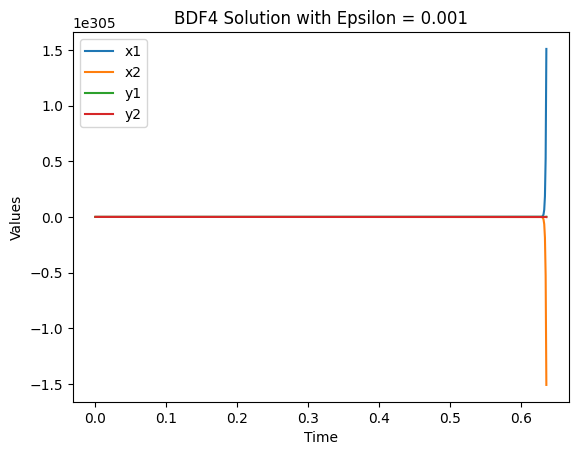

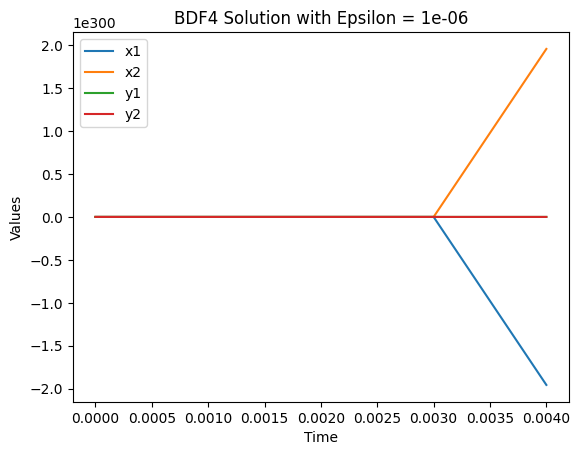

In [50]:
dt = 0.001 # time step
T_k = 20
N = int(T_k / dt)  # number of steps


initial_conditions = np.array([0, 0, 2, 0])  


def bdf4_step(y_old, y_old2, y_old3, y_old4, h, t_new, epsilon):
    y_new = y_old  
    for _ in range(100):  
        y_new_prev = y_new
        y_new = (48/25)*y_old - (36/25)*y_old2 + (16/25)*y_old3 - (3/25)*y_old4 + (12/25)*h*odes_system(t_new, y_new, epsilon)
        if np.allclose(y_new, y_new_prev, rtol=1e-5):
            break
    return y_new

# Example of solving for one value of epsilon
results = []
for epsilon in epsilons:
    times = np.arange(0, T_k, dt)
    bdf_results = np.empty((len(times), 4))  
    bdf_results[0] = initial_conditions
    # Use RK4 method for the initial steps
    for i in range(1, 4):
        bdf_results[i] = rk4_step(bdf_results[i-1], dt, times[i-1], epsilon)

    for i in range(4, len(times)):
        bdf_results[i] = bdf4_step(bdf_results[i-1], bdf_results[i-2], bdf_results[i-3], bdf_results[i-4], dt, times[i], epsilon)

    results.append(bdf_results)


time = np.linspace(0, T_k, N)

# Plot for each epsilon
for epsilon, result in zip(epsilons, results):
    # Assuming result is structured as [time_step, variable (x1, x2, y1, y2)]
    x1, x2, y1, y2 = result.T  # Transpose to get them by variables

    fig, ax = plt.subplots()
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'BDF4 Solution with Epsilon = {epsilon}')
    ax.legend()

plt.show()    

## BDF 3 порядка

Попробуем понизить порядок метода, чтобы получить сходящееся решение

Как видим, оно тоже расходится

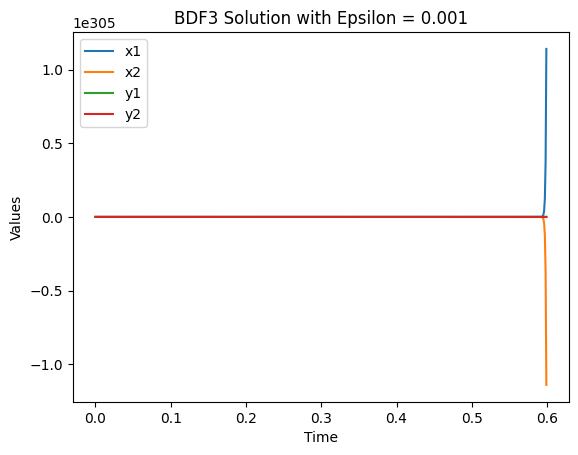

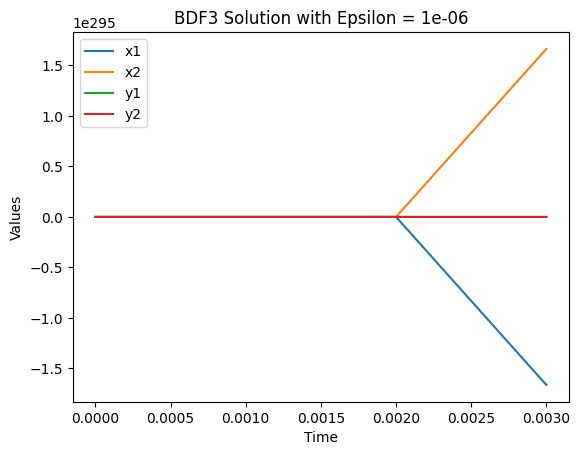

In [51]:
dt = 0.001 # time step
T_k = 20
N = int(T_k / dt)  # number of steps


def bdf3_step(y_old, y_old2, y_old3, h, t_new, epsilon):
    y_new = y_old 
    for _ in range(100):  
        y_new_prev = y_new
        y_new = (18/11)*y_old - (9/11)*y_old2 + (2/11)*y_old3 + (6/11)*h*odes_system(t_new, y_new, epsilon)
        if np.allclose(y_new, y_new_prev, rtol=1e-5):
            break
    return y_new


initial_conditions = np.array([0, 0, 2, 0])  

results = []
for epsilon in epsilons:
    times = np.arange(0, T_k, dt)
    bdf_results = np.empty((len(times), 4))
    bdf_results[0] = initial_conditions
    # Use RK4 method for the initial steps
    for i in range(1, 3):
        bdf_results[i] = rk4_step(bdf_results[i-1], dt, times[i-1], epsilon)
  
    for i in range(3, len(times)):
        bdf_results[i] = bdf3_step(bdf_results[i-1], bdf_results[i-2], bdf_results[i-3], dt, times[i], epsilon)

    results.append(bdf_results)


time = np.linspace(0, T_k, N)

# Plots
for epsilon, result in zip(epsilons, results):
    x1, x2, y1, y2 = result.T

    fig, ax = plt.subplots()
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'BDF3 Solution with Epsilon = {epsilon}')
    ax.legend()

plt.show()

## Неявный ФДН в представлении Нордсика

C:\Users\danii\AppData\Local\Temp\ipykernel_20808\1876055839.py:20: RuntimeWarning: overflow encountered in matmul
  delta = h_step * fn(t_n, x_n, epsilon) - np.dot(e1, np.matmul(P, z))
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\1876055839.py:21: RuntimeWarning: overflow encountered in matmul
  z = np.matmul(P, z) + np.outer(l, delta)
c:\Github\computational_mathematics\.venv\Lib\site-packages\matplotlib\ticker.py:2098: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


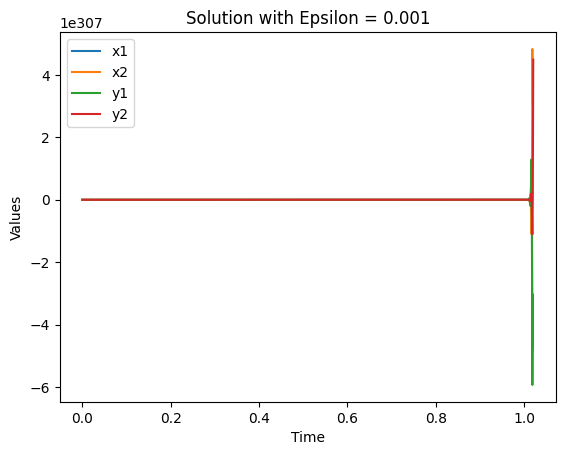

C:\Users\danii\AppData\Local\Temp\ipykernel_20808\1511849171.py:14: RuntimeWarning: overflow encountered in scalar divide
  dx1_dt = (-alpha * (y1 - y2) + phi(x1) - x2) / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\1511849171.py:15: RuntimeWarning: overflow encountered in scalar divide
  dx2_dt = (alpha * (y1 - y2) + phi(x2) - x1) / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\1511849171.py:9: RuntimeWarning: invalid value encountered in tan
  phi = lambda u: -np.tan(np.pi * u / 2)  # phi function
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\1876055839.py:20: RuntimeWarning: invalid value encountered in matmul
  delta = h_step * fn(t_n, x_n, epsilon) - np.dot(e1, np.matmul(P, z))
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\1876055839.py:21: RuntimeWarning: invalid value encountered in matmul
  z = np.matmul(P, z) + np.outer(l, delta)


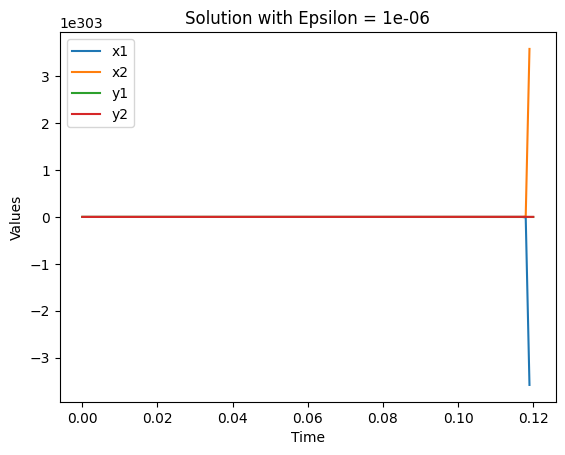

In [45]:
def Nordsik_Solve(l, fn, t_0, x_0, h_step, n_iters, epsilon): 
    
    x_points = [x_0] # Initial conditions appended first
    t_points = [t_0] # Initial time appended first

    t_n = t_0
    x_n = x_0

    k = len(l)
    P = scipy.linalg.pascal(k, kind='upper')
    l = np.array(l)
    e1 = np.zeros(k)
    e1[0] = 1.0 # Ensuring first element is changed to 1 as it seems intended for a vector operation

    z = np.zeros((k, *x_0.shape)) # Assuming x_0 is an ndarray
    z[0] = x_0
    
    for i in range(n_iters):

        delta = h_step * fn(t_n, x_n, epsilon) - np.dot(e1, np.matmul(P, z))
        z = np.matmul(P, z) + np.outer(l, delta)
        
        x_n = z[0]
        t_n += h_step

        x_points.append(x_n)
        t_points.append(t_n)

    return np.array(t_points), np.array(x_points)

l = np.array([251/720, 1, 11/12, 1/3, 1/24])
dt = 0.001 # time step
T_k = 20
N = int(T_k / dt)  # number of steps

for epsilon in epsilons:

    t_points, points = Nordsik_Solve(l, odes_system, 0, initial_conditions, h_step = dt, n_iters = N, epsilon= epsilon)
    fig, ax = plt.subplots()
    ax.plot(t_points, points[:, 0], label='x1')
    ax.plot(t_points, points[:, 1], label='x2')
    ax.plot(t_points, points[:, 2], label='y1')
    ax.plot(t_points, points[:, 3], label='y2')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Solution with Epsilon = {epsilon}')
    ax.legend()
    plt.show()

## 3) Методы Розенброка (Розенброка-Ванера)


#### Метод из библиотеки, чтобы было с чем сравнивать

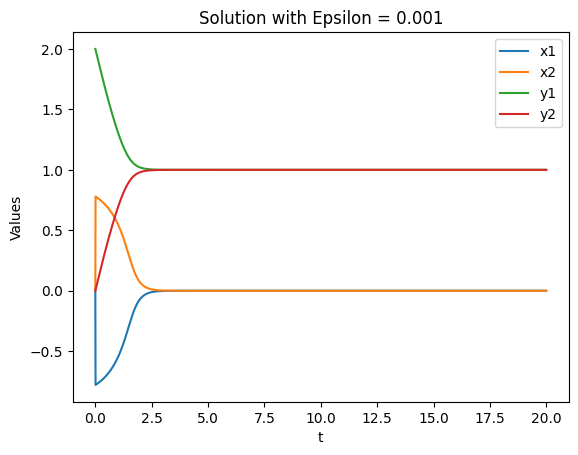

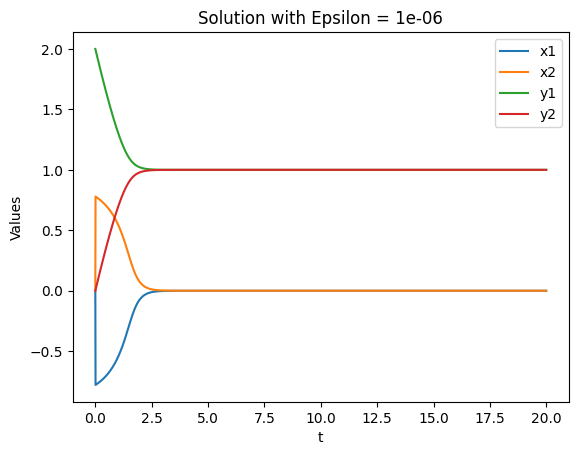

In [53]:
dt = 0.01

# Initial conditions
init_values = [0, 0, 2, 0]


results = []  # To store the solutions for different epsilons

# time array
time = np.linspace(0, T_k, int(T_k/dt))

# Solve the system for each epsilon
for epsilon in epsilons:
    sol = solve_ivp(odes_system, [0, T_k], init_values, method='Radau', t_eval=time, args=[epsilon])
    results.append((time, sol.y))  # Store the time stamps and the corresponding solutions

# Plot results
for epsilon, (time, result) in zip(epsilons, results):
    x1, x2, y1, y2 = result  # Assuming result is already in the desired shape

    fig, ax = plt.subplots()
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_xlabel('t')
    ax.set_ylabel('Values')
    ax.set_title(f'Solution with Epsilon = {epsilon}')
    ax.legend()

plt.show()


#### Реализация Метода Розенброка

Расходится для epsilon 10e^-6

C:\Users\danii\AppData\Local\Temp\ipykernel_20808\455535816.py:14: RuntimeWarning: overflow encountered in scalar divide
  dx1_dt = (-alpha * (y1 - y2) + phi(x1) - x2) / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\455535816.py:15: RuntimeWarning: overflow encountered in scalar divide
  dx2_dt = (alpha * (y1 - y2) + phi(x2) - x1) / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\455535816.py:9: RuntimeWarning: invalid value encountered in tan
  phi = lambda u: -np.tan(np.pi * u / 2)  # phi function
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\3611646877.py:7: RuntimeWarning: invalid value encountered in cos
  dfdx[0, 0] = (-np.pi / (2 * epsilon)) * (1 / (np.cos(np.pi * x1 / 2))**2) - 1 / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_20808\3611646877.py:12: RuntimeWarning: invalid value encountered in cos
  dfdx[1, 1] = (-np.pi / (2 * epsilon)) * (1 / (np.cos(np.pi * x2 / 2))**2) - 1 / epsilon


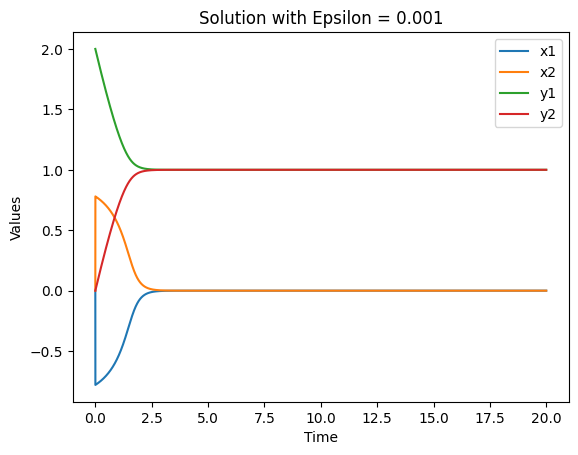

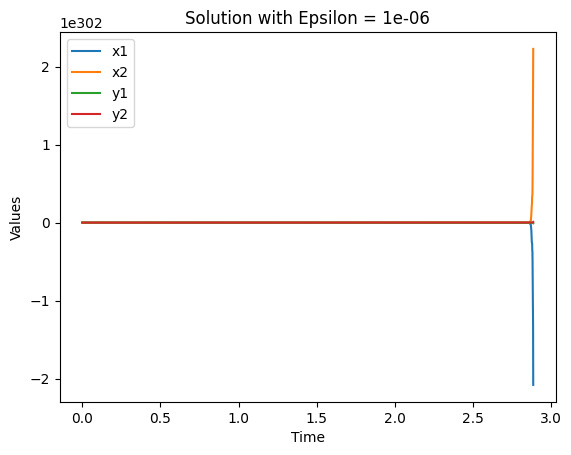

In [54]:
dt = 0.0005  # time step
N = int(T_k / dt)  # number of steps

def jacobian(t, vars, epsilon):
    x1, x2, _, _ = vars
    dfdx = np.zeros((4, 4))
    dfdx[0, 0] = (-np.pi / (2 * epsilon)) * (1 / (np.cos(np.pi * x1 / 2))**2) - 1 / epsilon
    dfdx[0, 1] = -1 / epsilon
    dfdx[0, 2] = -alpha / epsilon
    dfdx[0, 3] = alpha / epsilon
    dfdx[1, 0] = -1 / epsilon
    dfdx[1, 1] = (-np.pi / (2 * epsilon)) * (1 / (np.cos(np.pi * x2 / 2))**2) - 1 / epsilon
    dfdx[1, 2] = alpha / epsilon
    dfdx[1, 3] = -alpha / epsilon
    dfdx[2, 0] = 1
    dfdx[3, 1] = 1
    return dfdx

def rosenbrock_solver(system, jac, initial_values, time, epsilon):
    vars = np.array(initial_values, dtype=float)
    dt = time[1] - time[0]
    history = np.empty((len(time), len(vars)))
    
    for i, t in enumerate(time):
        history[i] = vars
        F = system(t, vars, epsilon)
        J = jac(t, vars, epsilon)
        Gamma = J - np.eye(len(vars)) / dt
        inv_Gamma = np.linalg.inv(Gamma)
        delta = np.dot(inv_Gamma, F)
        vars -= delta  
    return history

init_values = [0, 0, 2, 0]
results = {}
time = np.linspace(0, T_k, N)

for epsilon in epsilons:
    history = rosenbrock_solver(odes_system, jacobian, init_values, time, epsilon)
    results[epsilon] = history  
    

    x1, x2, y1, y2 = history.T 
    
    fig, ax = plt.subplots()
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Solution with Epsilon = {epsilon}')
    ax.legend()

plt.show()